In [48]:
import numpy as np
import PIL
import itertools
from matplotlib import pyplot as plt
import cv2
from os import listdir
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
import h5py

In [49]:
# Progress bar widget
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size} / {percentage:.2f}%'.format(
                        name=name,
                        index=index,
                        size=size,
                        percentage=index*100.0/size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [50]:
# Define the paths to the folders containing the files
path_positive_train = "data/train/pedestrians/"
path_negative_train = "data/train/background/"
path_positive_test = "data/test/pedestrians/"
path_negative_test = "data/test/background/"
example_positive = path_positive_test + "AnnotationsPos_0.000000_crop001001b_0.png"
example_negative = path_negative_test + "AnnotationsNeg_0.000000_00000002a_0.png"

In [51]:
def data_from_dir(input_dir):
    # List the files in the input_dir (pre-prend the dir)
    file_list = [input_dir+f for f in listdir(input_dir) if f.endswith(".png")]
    # Read the files (parallel style)
    images = Parallel(n_jobs=-2)(delayed(lambda x:cv2.imread(x)[:,:,::-1])(im_path) for im_path in file_list)
#     images = [cv2.imread(im_path)[:,:,::-1] for im_path in file_list]

    # Return as an array
    return np.array(images)

def load_data(pos_path, neg_path):
    # Load positives
    pos_data = data_from_dir(pos_path)
    # Load negatives
    neg_data = data_from_dir(neg_path)
    # Concatenate them
    all_data = np.concatenate([pos_data, neg_data], axis=0)
    # Set the labels
    all_labels = np.zeros(all_data.shape[0], dtype='int32')
    all_labels[:pos_data.shape[0]] = 1
    
    return all_data, all_labels

In [197]:
# From the scikit-learn docs... https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    print("Confusion matrix:\n", cm)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##############################################################################################################

# Again from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_ROC(y_true, y_pred):
    # Compute ROC curve and ROC area
    for i in range(2):
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

##############################################################################################################

# Pack everything in a single function :D
def test_model(in_model, in_data, t_labels, prints=False):
    # Predict the new data
    # Using flags = True we retrieve the distance to the decision plane; negative means "positive" or 1, positive "false" or 0
    _, p_scores_raw = in_model.predict(in_data, flags=True)
    # Use a softmax to get something that looks like a [0,1] score
    # Don't use the negative value (as we'd have to then compute the complimentary scores again)
    #p_scores = 1 - (1/(1+np.exp(-p_scores_raw)))
    p_scores = 1/(1+np.exp(p_scores_raw))
    # Get the labels thresholding the raw scores (if negative, label is 1, if positive, label is 0)
    p_labels = np.int32(p_scores_raw < 0)
    t_labels = np.int32(t_labels)
    
    # Evaluate the results
    cm = metrics.confusion_matrix(t_labels, p_labels)
    accuracy = metrics.accuracy_score(t_labels, p_labels)
    precision = metrics.precision_score(t_labels, p_labels)
    recall = metrics.recall_score(t_labels, p_labels)
    f1 = metrics.f1_score(t_labels, p_labels)
    auc = metrics.roc_auc_score(t_labels, p_scores)
    
    if(prints):
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        print("AUC score:", auc)

        plot_confusion_matrix(cm, classes=("Background", "Pedestrian"), normalize=True)
        plot_ROC(t_labels, p_scores)
    
    return accuracy, precision, recall, f1, auc

In [83]:
class LBPDescriptor():
    def __init__(self, in_kernel_size=3, in_border_policy=cv2.BORDER_REPLICATE, in_block_size=16, in_block_step=8):
        self.border_policy = in_border_policy
        self.kernel_size = in_kernel_size
        self.block_size = in_block_size
        self.block_step = in_block_step
        # Get the binary values to match the way numpy unwraps the matrix to the way LBP is described
        # This is simply the "weight" in the binary number
        self.LBP_bin_values = np.array([[128,64,32],[1,0,16],[2,4,8]], dtype='uint8')
        
    def compute_array(self, input_array):
        descriptors = Parallel(n_jobs=-2)(delayed(lambda x:self.compute(x))(img) for img in log_progress(input_array, name="Descriptors:"))
        return np.array(descriptors, dtype='float32')
    
    def compute_block(self, input_block):
        output_lbp_block = np.zeros(input_block.shape, dtype='uint8')
        
        border_size = int(1.0*self.kernel_size/2)
        # The block is already the right size (should be!)
        # extended_block = cv2.copyMakeBorder(input_block, border_size, border_size, border_size, border_size, self.border_policy)
        extended_block = input_block
        
        # Compute only the "inner" part of the block, as the rest is a border
        conv_start_x = border_size
        conv_start_y = border_size
        conv_end_x = input_block.shape[0] - border_size
        conv_end_y = input_block.shape[1] - border_size

        # Convolve the extended image computing the LBP descriptor at each point
        for x in np.arange(conv_start_x, conv_end_x):
            for y in np.arange(conv_start_y, conv_end_y):
                half_kernel = int(self.kernel_size/2)
                window = extended_block[x-half_kernel:x+half_kernel+1, y-half_kernel:y+half_kernel+1]
                half_window = int(window.shape[0]/2)
                window_mask = (window >= window[half_window,half_window])
                score = np.sum(self.LBP_bin_values[window_mask])
                output_lbp_block[x-conv_start_x,y-conv_start_y] = score
        # Get the histograms, normalized using density=True
        output_descriptor, _ = np.histogram(output_lbp_block, bins=np.arange(256), density=True)
        
        return output_descriptor
    
    
    def compute(self, input_image):
        # Change to BW
        if(len(input_image.shape) > 2):
            input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
            
        output_lbp = []
        
        # Extend the image borders
        border_size = int(1.0*self.kernel_size/2)
        extended_img = cv2.copyMakeBorder(input_image, border_size, border_size, border_size, border_size, self.border_policy)
        
        # Slide a window (each block) across the image and compute each LBP
        for ii in np.arange(0, input_image.shape[0], self.block_step):
            for jj in np.arange(0, input_image.shape[1], self.block_step):
                block = extended_img[ii:(ii+2*border_size+self.block_size), jj:(jj+2*border_size+self.block_size)]
                # If the block is "full size"
                if(np.prod(block.shape) == ((self.block_size+2*border_size)**2)):
                    lbp_block = self.compute_block(block)
                    output_lbp.append(lbp_block)
        # Reshape to flatten the array and add an extra dimension that the SVM opencv classifier requires
        return np.array(output_lbp).reshape(-1,1)
                        
    def get_point_LBP(self, input_window):
        # Compare the values to the central value of the window
        half_window = int(input_window.shape[0]/2)
        out_LBP = (input_window >= input_window[half_window, half_window])
        return np.sum(self.LBP_bin_values[out_LBP])

In [54]:
%%time
# Load the training data
train_images, train_labels = load_data(path_positive_train, path_negative_train)

# Load the test data
test_images, test_labels = load_data(path_positive_test, path_negative_test)

CPU times: user 764 ms, sys: 292 ms, total: 1.06 s
Wall time: 1.55 s


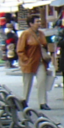

In [55]:
# Print an image to check it's alright
PIL.Image.fromarray(train_images[0])

In [56]:
# Get the descriptors
hog = cv2.HOGDescriptor()
lbp = LBPDescriptor()

In [57]:
%%time
# Compute the hog
train_descriptors_hog = np.array([hog.compute(img) for img in log_progress(train_images, name='Descriptors')])
test_descriptors_hog = np.array([hog.compute(img) for img in log_progress(test_images, name='Descriptors')])

CPU times: user 1.48 s, sys: 64 ms, total: 1.55 s
Wall time: 1.46 s


In [58]:
%%time

# train_descriptors_lbp = lbp.compute_array(train_images)
# test_descriptors_lbp = lbp.compute_array(test_images)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [59]:
# Skip the pain of extracting the values D8 (15m ~)
fo = h5py.File("data/LBP_descriptors", "x")
fo.create_dataset("train", data=train_descriptors_lbp, chunks=True, compression='lzf')
fo.create_dataset("test", data=test_descriptors_lbp, chunks=True, compression='lzf')
fo.close()

OSError: Unable to create file (unable to open file: name = 'data/LBP_descriptors', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [60]:
%%time
# Read from the dataset
fi = h5py.File("data/LBP_descriptors", "r")
train_descriptors_lbp = fi["train"][:]
test_descriptors_lbp = fi["test"][:]
fi.close()

CPU times: user 1.37 s, sys: 104 ms, total: 1.48 s
Wall time: 1.47 s


In [61]:
# Put all together to use cross validation
all_hog = np.concatenate([train_descriptors_hog, test_descriptors_hog], axis=0)
all_lbp = np.concatenate([train_descriptors_lbp, test_descriptors_lbp], axis=0)
all_labels = np.concatenate([train_labels, test_labels], axis=0)

In [84]:
def get_model(svm_type = cv2.ml.SVM_C_SVC, kernel_type = cv2.ml.SVM_LINEAR, degree = None, gamma=None, Cval = None, class_weights=None):
    # Build and return a classifier
    model = cv2.ml.SVM_create()
    # Apply the parameters
    model.setType(svm_type)
    model.setKernel(kernel_type)
    if(not degree is None):
        model.setDegree(degree)
    if(not gamma is None):
        model.setGamma(gamma)
    if(not Cval is None):
        model.setC(Cval)
    if(not class_weights is None):
        model.setClassWeights(class_weights)
    
    return model

In [143]:
train_data = train_descriptors_hog
test_data = test_descriptors_hog

In [144]:
%%time
model = get_model()
# Train the classifier
model.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

CPU times: user 4.15 s, sys: 24 ms, total: 4.17 s
Wall time: 4.17 s


### Ejercicio 1 (obligatorio): Uso de SVM + HoG

### Objetivo 1: Función para reportar la calidad de un clasificador

Accuracy: 0.9672727272727273
Precision: 0.9734693877551021
Recall: 0.954
F1 score: 0.9636363636363635
AUC score: 0.9931533333333332
Confusion matrix:
 [[587  13]
 [ 23 477]]


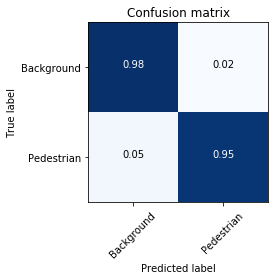

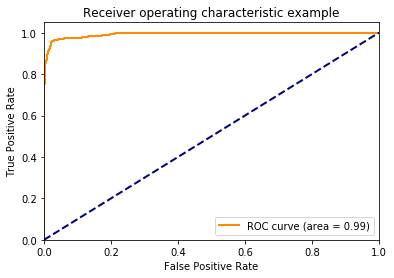

In [198]:
_ = test_model(model, test_data, test_labels, prints=True)

### Objetivo 2: Implementar estrategia de validación (en este caso 5-fold cross validation)

In [259]:
# Small helper function
def train_test_model(model, train, test):
    # Split the data
    train_data, train_labels = train
    test_data, test_labels = test
    # Train the model
    model.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)
    # Test the model
    return test_model(model, test_data, test_labels)

# CV Function
def crossval_dset(data, labels, model_generator, nfolds=5):
    # Define the k-fold cross validation object
    skf = StratifiedKFold(n_splits=nfolds, shuffle=True)
    skf.get_n_splits(data, labels)
    results = []
    
    for train_idx, test_idx in log_progress(skf.split(all_data, all_labels), size=nfolds, name="Train/Testing folds"):
        # Split the data
        train_data = data[train_idx]
        train_labels = labels[train_idx]
        test_data = data[test_idx]
        test_labels = labels[test_idx]
        # Get a model
        model_cv = model_generator()
        # Train and test the model, save the results, and iterate
        results.append(train_test_model(model_cv, (train_data, train_labels), (test_data, test_labels)))
    
    return np.array(results)

In [ ]:
%%time

# Select a data source
all_data = all_hog
# all_data = all_lbp

# Modify model_f to get a fresh model every time
model_f = lambda:get_model()

# Perform cross validation
results_0 = crossval_dset(all_data, all_labels, model_f)

# Resultados con parámetros por defecto
print("Means(%)", 100*np.mean(results_0, axis=1))
print("STDev(%)", 100*np.std(results_0, axis=1))

### Objetivo 3: Exploración del espacio de hiper-parámetros

In [208]:
# Select a data source
# HOG
all_data = all_hog
# LBP
# all_data = all_lbp
# HOG + LBP Concatenated
# all_data = np.concatenate([all_hog, all_lbp], axis=1)

In [124]:
%%time
# Kernel lineal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_LINEAR)

# Perform cross validation
results_hog_linear = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_linear, axis=1))
print("STDev(%)", 100*np.std(results_hog_linear, axis=1))

Means(%) [96.19922232 96.21688541 95.7852825  95.50684983 95.96412127]
STDev(%) [0.54113254 0.23225156 0.66813829 0.3901401  1.04047878]
CPU times: user 21.4 s, sys: 192 ms, total: 21.6 s
Wall time: 21.5 s


In [125]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2)

# Perform cross validation
results_hog_poly_2 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_2, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_2, axis=1))

Means(%) [97.08149088 97.0658735  97.47702852 97.179241   97.21143942]
STDev(%) [0.84651112 1.10748895 0.8486452  0.78418854 0.1912221 ]
CPU times: user 38.5 s, sys: 196 ms, total: 38.7 s
Wall time: 27.3 s


In [142]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [98.33766453 98.81377381 98.32788496 95.9747584  98.22536653]
STDev(%) [0.45654942 0.14456583 0.33371173 1.60293032 0.27412842]
CPU times: user 2min 54s, sys: 1.2 s, total: 2min 55s
Wall time: 2min 9s


In [128]:
%%time
# Kernel sigmoidal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_SIGMOID)

# Perform cross validation
results_hog_sigmoid = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_sigmoid, axis=1))
print("STDev(%)", 100*np.std(results_hog_sigmoid, axis=1))

Means(%) [60.30688089 60.27668298 52.92604226 60.32810982 52.32334733]
STDev(%) [20.80118792 20.81570716  2.64406659 20.78813391  2.47038663]
CPU times: user 1min 30s, sys: 264 ms, total: 1min 30s
Wall time: 1min 3s


In [129]:
%%time
# Kernel radial

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_RBF)

# Perform cross validation
results_hog_radial = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_radial, axis=1))
print("STDev(%)", 100*np.std(results_hog_radial, axis=1))

Means(%) [88.81318638 90.52877459 85.87272344 85.97429956 86.33940243]
STDev(%) [5.23536587 3.68943063 6.54240902 6.76248074 5.59885592]
CPU times: user 2min 25s, sys: 240 ms, total: 2min 25s
Wall time: 1min 40s


### Vamos a continuar con el kernel polinómico, el mejor resultado con parámetros por defecto, cambiando C

In [209]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.125)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [97.55429984 98.58524443 97.91797689 97.90586146 97.57451277]
STDev(%) [1.58552493 0.85008685 1.4367012  1.05798662 1.33914093]
CPU times: user 50 s, sys: 140 ms, total: 50.1 s
Wall time: 35.3 s


In [210]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.5)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [98.13173923 97.6341127  97.48585953 98.48769221 97.10832335]
STDev(%) [1.16121131 1.32009565 1.40223214 1.10803067 1.44145896]
CPU times: user 49.7 s, sys: 136 ms, total: 49.8 s
Wall time: 35.1 s


In [211]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=1.0)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [97.90598728 98.41841198 97.7348873  97.90350491 97.3845305 ]
STDev(%) [1.31315547 0.99462734 1.27348145 1.41849274 1.63812176]
CPU times: user 50 s, sys: 168 ms, total: 50.2 s
Wall time: 35.4 s


In [212]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=2.0)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [97.7709965  98.07106903 97.3763002  98.48201968 97.64276819]
STDev(%) [1.40804563 1.37498039 1.5287613  0.72336479 1.33266078]
CPU times: user 50 s, sys: 116 ms, total: 50.1 s
Wall time: 35.3 s


In [213]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=8.0)

# Perform cross validation
results_hog_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_hog_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_hog_poly_5, axis=1))

Means(%) [98.56827467 98.06332243 97.56521141 97.82619674 97.30423702]
STDev(%) [0.73201259 1.16118966 1.41364331 1.21408635 1.71666995]
CPU times: user 49.9 s, sys: 152 ms, total: 50 s
Wall time: 35.2 s


### Ejercicio 2 (obligatorio): Uso de SVM + LBP básico

In [273]:
# Select a data source
# HOG
# all_data = all_hog
# LBP
all_data = all_lbp
# HOG + LBP Concatenated
# all_data = np.concatenate([all_hog, all_lbp], axis=1)

In [215]:
%%time
# Kernel lineal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_LINEAR)

# Perform cross validation
results_lbp_linear = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_linear, axis=1))
print("STDev(%)", 100*np.std(results_lbp_linear, axis=1))

Means(%) [97.93490409 97.83481316 98.81765617 98.35051631 97.82858121]
STDev(%) [1.09496484 0.91621954 0.53511995 0.74079311 0.90384852]
CPU times: user 2min 23s, sys: 1.2 s, total: 2min 24s
Wall time: 2min 24s


In [216]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2)

# Perform cross validation
results_lbp_poly_2 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_2, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_2, axis=1))

Means(%) [98.07366283 99.08565349 98.52686978 98.19771702 98.77892838]
STDev(%) [0.87032338 0.39800751 0.70303609 1.16810086 0.58534665]
CPU times: user 3min 25s, sys: 1.21 s, total: 3min 27s
Wall time: 2min 30s


In [217]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5)

# Perform cross validation
results_lbp_poly_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5, axis=1))

Means(%) [98.30802781 98.32243719 98.47331413 98.45600315 98.61878255]
STDev(%) [0.65065802 0.79714848 1.01268015 0.98801031 0.85512114]
CPU times: user 3min 9s, sys: 1.08 s, total: 3min 10s
Wall time: 2min 20s


In [218]:
%%time
# Kernel sigmoidal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_SIGMOID)

# Perform cross validation
results_lbp_sigmoid = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_sigmoid, axis=1))
print("STDev(%)", 100*np.std(results_lbp_sigmoid, axis=1))

Means(%) [24.03920726 22.53236517 23.93229223 23.34858676 25.67260043]
STDev(%) [2.97597688 3.72426302 2.89221783 3.4182892  3.07675998]
CPU times: user 10min 41s, sys: 1.28 s, total: 10min 42s
Wall time: 7min 28s


In [219]:
%%time
# Kernel radial

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_RBF)

# Perform cross validation
results_lbp_radial = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_radial, axis=1))
print("STDev(%)", 100*np.std(results_lbp_radial, axis=1))

Means(%) [98.27762448 97.24461455 97.76964775 97.93781228 98.19803061]
STDev(%) [0.81715494 1.5439759  1.32616577 1.04546814 0.93638216]
CPU times: user 10min 49s, sys: 1.3 s, total: 10min 50s
Wall time: 7min 49s


### Vamos a continuar con el kernel polinómico de nuevo, el mejor resultado con parámetros por defecto, cambiando C

In [233]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.125)

# Perform cross validation
results_lbp_poly_5_1 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5_1, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5_1, axis=1))

Means(%) [97.33715435 98.00596371 98.14738732 97.95112112 97.30842143]
STDev(%) [1.47687525 1.17837609 0.99787227 1.40842218 1.93040188]
CPU times: user 46.2 s, sys: 268 ms, total: 46.5 s
Wall time: 35.5 s


In [234]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.5)

# Perform cross validation
results_lbp_poly_5_2 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5_2, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5_2, axis=1))

Means(%) [97.75119154 97.64071503 97.78174268 97.31061571 98.5826824 ]
STDev(%) [1.28921367 1.73556435 1.24171878 1.29091813 0.84640123]
CPU times: user 46.8 s, sys: 176 ms, total: 47 s
Wall time: 35.9 s


In [235]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=1.0)

# Perform cross validation
results_lbp_poly_5_3 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5_3, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5_3, axis=1))

Means(%) [98.15696104 97.48954514 97.20347354 98.75572786 97.72600998]
STDev(%) [1.19306853 1.49753752 1.57223983 0.90521291 1.09706102]
CPU times: user 46.6 s, sys: 208 ms, total: 46.8 s
Wall time: 35.7 s


In [236]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=2.0)

# Perform cross validation
results_lbp_poly_5_4 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5_4, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5_4, axis=1))

Means(%) [97.71795842 98.41390994 97.24432746 97.98934377 98.05974648]
STDev(%) [1.53715988 0.89684398 1.63137037 1.45187203 0.97770652]
CPU times: user 46.3 s, sys: 196 ms, total: 46.5 s
Wall time: 35.4 s


In [237]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=8.0)

# Perform cross validation
results_lbp_poly_5_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbp_poly_5_5, axis=1))
print("STDev(%)", 100*np.std(results_lbp_poly_5_5, axis=1))

Means(%) [98.07915675 97.75401345 97.81533793 98.17787069 97.7422938 ]
STDev(%) [1.37760736 1.48835816 0.92897983 0.9665505  1.6808964 ]
CPU times: user 46.2 s, sys: 176 ms, total: 46.4 s
Wall time: 35.4 s


### Ejercicio 3 (voluntario): Implementación y uso de SVM + LBP uniforme

In [227]:
class LBPuDescriptor():
    def __init__(self, in_kernel_size=3, in_border_policy=cv2.BORDER_REPLICATE, in_block_size=16, in_block_step=8):
        self.border_policy = in_border_policy
        self.kernel_size = in_kernel_size
        self.block_size = in_block_size
        self.block_step = in_block_step
        # Get the binary values to match the way numpy unwraps the matrix to the way LBP is described
        # This is simply the "weight" in the binary number
        self.LBP_bin_values = np.array([[128,64,32],[1,0,16],[2,4,8]], dtype='uint8')
        
        # Instead of computing a look up table...
        # Look up table graciously donated by https://stackoverflow.com/questions/35747924/how-to-implement-lbp-uniform
        self.uniform_LUT = [0,1,2,3,4,58,5,6,7,58,58,58,8,58,9,10,11,58,58,58,58,58,58,58,12,58,58,58,13,58,
        14,15,16,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,17,58,58,58,58,58,58,58,18,
        58,58,58,19,58,20,21,22,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,58,58,58,58,58,58,58,58,58,58,58,23,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,58,24,58,58,58,58,58,58,58,25,58,58,58,26,58,27,28,29,30,58,31,58,58,58,32,58,
        58,58,58,58,58,58,33,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,34,58,58,58,58,
        58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,
        58,35,36,37,58,38,58,58,58,39,58,58,58,58,58,58,58,40,58,58,58,58,58,58,58,58,58,
        58,58,58,58,58,58,41,42,43,58,44,58,58,58,45,58,58,58,58,58,58,58,46,47,48,58,49,
        58,58,58,50,51,52,58,53,54,55,56,57]
        
    def compute_array(self, input_array):
        descriptors = Parallel(n_jobs=-2)(delayed(lambda x:self.compute(x))(img) for img in log_progress(input_array, name="Descriptors:"))
        return np.array(descriptors, dtype='float32')
    
    def compute_block(self, input_block):
        output_lbp_block = np.zeros(input_block.shape, dtype='uint8')
        
        border_size = int(1.0*self.kernel_size/2)
        # The block is already the right size (should be!)
        # extended_block = cv2.copyMakeBorder(input_block, border_size, border_size, border_size, border_size, self.border_policy)
        extended_block = input_block
        
        # Compute only the "inner" part of the block, as the rest is a border
        conv_start_x = border_size
        conv_start_y = border_size
        conv_end_x = input_block.shape[0] - border_size
        conv_end_y = input_block.shape[1] - border_size

        # Convolve the extended image computing the LBP descriptor at each point
        for x in np.arange(conv_start_x, conv_end_x):
            for y in np.arange(conv_start_y, conv_end_y):
                half_kernel = int(self.kernel_size/2)
                window = extended_block[x-half_kernel:x+half_kernel+1, y-half_kernel:y+half_kernel+1]
                half_window = int(window.shape[0]/2)
                window_mask = (window >= window[half_window,half_window])
                score = np.sum(self.LBP_bin_values[window_mask])
                # Instead of the raw score, transform to uniform with the look up table
                output_lbp_block[x-conv_start_x,y-conv_start_y] = self.uniform_LUT[score]
        # Get the histograms, normalized using density=True
        # Also use bins from 0 to 59, since it's the range of values for the uniform LBP
        output_descriptor, _ = np.histogram(output_lbp_block, bins=np.arange(59), density=True)
        
        return output_descriptor
    
    
    def compute(self, input_image):
        # Change to BW
        if(len(input_image.shape) > 2):
            input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
            
        output_lbp = []
        
        # Extend the image borders
        border_size = int(1.0*self.kernel_size/2)
        extended_img = cv2.copyMakeBorder(input_image, border_size, border_size, border_size, border_size, self.border_policy)
        
        # Slide a window (each block) across the image and compute each LBP
        for ii in np.arange(0, input_image.shape[0], self.block_step):
            for jj in np.arange(0, input_image.shape[1], self.block_step):
                block = extended_img[ii:(ii+2*border_size+self.block_size), jj:(jj+2*border_size+self.block_size)]
                # If the block is "full size"
                if(np.prod(block.shape) == ((self.block_size+2*border_size)**2)):
                    lbp_block = self.compute_block(block)
                    output_lbp.append(lbp_block)
        # Reshape to flatten the array and add an extra dimension that the SVM opencv classifier requires
        return np.array(output_lbp).reshape(-1,1)
                        
    def get_point_LBP(self, input_window):
        # Compare the values to the central value of the window
        half_window = int(input_window.shape[0]/2)
        out_LBP = (input_window >= input_window[half_window, half_window])
        return np.sum(self.LBP_bin_values[out_LBP])

In [228]:
%%time
# Compute the uniform LBP
lbpu = LBPuDescriptor()
# train_descriptors_lbpu = lbpu.compute_array(train_images)
# test_descriptors_lbpu = lbpu.compute_array(test_images)

CPU times: user 37.4 s, sys: 740 ms, total: 38.2 s
Wall time: 5min 50s


In [229]:
# Skip the pain of extracting the values D8 (15m ~)
fo = h5py.File("data/LBPu_descriptors", "x")
fo.create_dataset("train", data=train_descriptors_lbpu, chunks=True, compression='lzf')
fo.create_dataset("test", data=test_descriptors_lbpu, chunks=True, compression='lzf')
fo.close()

In [230]:
%%time
# Read from the dataset
fi = h5py.File("data/LBPu_descriptors", "r")
train_descriptors_lbpu = fi["train"][:]
test_descriptors_lbpu = fi["test"][:]
fi.close()

CPU times: user 371 ms, sys: 24 ms, total: 395 ms
Wall time: 395 ms


In [243]:
# Put all together to use cross validation
all_lbpu = np.concatenate([train_descriptors_lbpu, test_descriptors_lbpu], axis=0)

In [286]:
# Select a data source
# HOG
# all_data = all_hog
# LBP
# all_data = all_lbp
# HOG + LBP Concatenated
# all_data = np.concatenate([all_hog, all_lbp], axis=1)
# Uniform LBP
all_Data = all_lbpu

In [263]:
%%time
# Kernel lineal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_LINEAR)

# Perform cross validation
results_lbpu_linear = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_lbpu_linear, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_linear, axis=1))

Means(%) [96.93795171 95.96311565 97.09588509 95.90784181 96.71748685]
STDev(%) [1.66534327 1.74361119 1.14902307 1.896792   1.33721268]
CPU times: user 21.3 s, sys: 196 ms, total: 21.5 s
Wall time: 21.4 s


In [264]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2)

# Perform cross validation
results_lbpu_poly_2 = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_lbpu_poly_2, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_2, axis=1))

Means(%) [97.3990042  97.41473058 97.98089069 97.47820884 97.61639605]
STDev(%) [1.04937763 1.58279537 0.85845085 1.57749315 1.39127342]
CPU times: user 37.3 s, sys: 200 ms, total: 37.5 s
Wall time: 27.4 s


In [266]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5)

# Perform cross validation
results_lbpu_poly_5 = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_lbpu_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5, axis=1))

Means(%) [97.68151461 97.42242652 98.41917017 96.90845161 98.25206188]
STDev(%) [1.15266811 1.61034862 0.82438074 2.01789832 0.96053351]
CPU times: user 48.1 s, sys: 190 ms, total: 48.3 s
Wall time: 35.5 s


In [248]:
%%time
# Kernel sigmoidal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_SIGMOID)

# Perform cross validation
results_lbpu_sigmoid = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_sigmoid, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_sigmoid, axis=1))

/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Means(%) [56.94795963 54.3720774  21.0805522  21.0805522  21.0972746 ]
STDev(%) [ 3.65380673  3.25258506 25.87132787 25.87132787 25.89008935]
CPU times: user 1min 26s, sys: 284 ms, total: 1min 26s
Wall time: 1min 3s


/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [249]:
%%time
# Kernel radial

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_RBF)

# Perform cross validation
results_lbpu_radial = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_radial, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_radial, axis=1))

Means(%) [79.61492398 81.5957534  79.98940087 79.53618538 80.3490351 ]
STDev(%) [15.47231046 16.37651838 15.59724891 15.19530643 15.88270573]
CPU times: user 2min 18s, sys: 300 ms, total: 2min 19s
Wall time: 1min 40s


### Vamos a continuar con el kernel polinómico de nuevo, el mejor resultado con parámetros por defecto, cambiando C

In [288]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.125)

# Perform cross validation
results_lbpu_poly_5_1 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_poly_5_1, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5_1, axis=1))

Means(%) [97.35975318 97.91891247 97.6467151  98.17118945 98.33570446]
STDev(%) [1.59667312 1.15800176 1.33842564 1.1226049  1.49908284]
CPU times: user 1.09 ms, sys: 3 µs, total: 1.09 ms
Wall time: 821 µs


In [289]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=0.5)

# Perform cross validation
results_lbpu_poly_5_2 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_poly_5_2, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5_2, axis=1))

Means(%) [97.54806385 98.41135359 98.51033364 97.41512397 97.93975726]
STDev(%) [1.90424477 1.08481724 0.93416765 1.26231437 1.28676962]
CPU times: user 575 µs, sys: 2 µs, total: 577 µs
Wall time: 436 µs


In [290]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=1.0)

# Perform cross validation
results_lbpu_poly_5_3 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_poly_5_3, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5_3, axis=1))

Means(%) [97.99648022 98.39959442 97.42353959 97.6318532  97.55360111]
STDev(%) [0.99503118 1.17768895 1.50579282 1.51231746 1.30702617]
CPU times: user 1.69 ms, sys: 0 ns, total: 1.69 ms
Wall time: 1.51 ms


In [291]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=2.0)

# Perform cross validation
results_lbpu_poly_5_4 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_poly_5_4, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5_4, axis=1))

Means(%) [98.2714464  97.31888647 98.51591008 97.52612519 97.30977654]
STDev(%) [1.1611152  1.63848182 0.72173658 1.55947386 1.72391463]
CPU times: user 974 µs, sys: 2 µs, total: 976 µs
Wall time: 726 µs


In [292]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5, Cval=8.0)

# Perform cross validation
results_lbpu_poly_5_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_lbpu_poly_5_5, axis=1))
print("STDev(%)", 100*np.std(results_lbpu_poly_5_5, axis=1))

Means(%) [97.48987901 97.40574391 98.25100838 97.0932884  98.34458598]
STDev(%) [1.58381467 1.47887494 0.88290665 1.91735552 1.08067197]
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.2 ms


### Ejercicio 4 (voluntario): Combinación de características, HOG + LBPu

In [294]:
# Select a data source
# HOG
# all_data = all_hog
# LBP
# all_data = all_lbp
# Uniform LBP
# all_Data = all_lbpu
# HOG + LBPu Concatenated
all_data = np.concatenate([all_hog, all_lbpu], axis=1)

In [295]:
%%time
# Kernel lineal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_LINEAR)

# Perform cross validation
results_combined_linear = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_combined_linear, axis=1))
print("STDev(%)", 100*np.std(results_combined_linear, axis=1))

Means(%) [98.15168908 97.92358791 97.5397425  98.84249885 97.68177587]
STDev(%) [0.84581176 1.08758617 1.16282829 0.53016064 1.06148759]
CPU times: user 44.9 s, sys: 444 ms, total: 45.3 s
Wall time: 45.2 s


In [296]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2)

# Perform cross validation
results_combined_poly_2 = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_combined_poly_2, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2, axis=1))

Means(%) [98.85431043 98.60588103 98.69281416 98.85791279 98.17268733]
STDev(%) [0.5282992  0.64782819 0.62171039 0.54059519 0.89077784]
CPU times: user 1min 20s, sys: 416 ms, total: 1min 20s
Wall time: 57.2 s


In [297]:
%%time
# Kernel polinómico grado 5

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=5)

# Perform cross validation
results_combined_poly_5 = crossval_dset(all_data, all_labels, model_f, nfolds=5)
print("Means(%)", 100*np.mean(results_combined_poly_5, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_5, axis=1))

Means(%) [98.85209    98.60889791 98.85200971 98.36346492 98.44991515]
STDev(%) [0.66035385 0.64821986 0.66488411 0.76615187 0.78329942]
CPU times: user 1min 54s, sys: 524 ms, total: 1min 55s
Wall time: 1min 21s


In [298]:
%%time
# Kernel sigmoidal

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_SIGMOID)

# Perform cross validation
results_combined_sigmoid = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_sigmoid, axis=1))
print("STDev(%)", 100*np.std(results_combined_sigmoid, axis=1))

/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/

Means(%) [21.05360444 21.06382979 21.06382979 21.06382979 21.06382979]
STDev(%) [25.83905175 25.85259605 25.85259605 25.85259605 25.85259605]
CPU times: user 3min 54s, sys: 576 ms, total: 3min 55s
Wall time: 2min 45s


/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/frgon/anaconda3/envs/vision/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [299]:
%%time
# Kernel radial

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_RBF)

# Perform cross validation
results_combined_radial = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_radial, axis=1))
print("STDev(%)", 100*np.std(results_combined_radial, axis=1))

Means(%) [83.83405585 81.91515393 82.77895595 81.84625501 85.33984944]
STDev(%) [16.95824845 16.01498739 16.77419193 16.46760696 17.53074481]
CPU times: user 6min 13s, sys: 652 ms, total: 6min 14s
Wall time: 4min 17s


In [300]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2, Cval=0.125)

# Perform cross validation
results_combined_poly_2_1 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_poly_2_1, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2_1, axis=1))

Means(%) [98.75582311 99.1018161  98.36197748 98.68433809 98.26606738]
STDev(%) [0.7089712  0.46984026 0.75942065 0.61563164 0.77556242]
CPU times: user 1min 19s, sys: 488 ms, total: 1min 20s
Wall time: 56.8 s


In [301]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2, Cval=0.5)

# Perform cross validation
results_combined_poly_2_2 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_poly_2_2, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2_2, axis=1))

Means(%) [98.13135383 99.08595924 98.01234316 98.99884339 99.02787671]
STDev(%) [0.90304797 0.44137067 0.9675611  0.67476705 0.60124419]
CPU times: user 1min 19s, sys: 476 ms, total: 1min 20s
Wall time: 57 s


In [302]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2, Cval=1)

# Perform cross validation
results_combined_poly_2_3 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_poly_2_3, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2_3, axis=1))

Means(%) [99.01926519 98.17402295 98.10436597 98.60741927 98.36365422]
STDev(%) [0.47675863 0.78738256 0.85574675 0.73160204 0.77957358]
CPU times: user 1min 20s, sys: 432 ms, total: 1min 20s
Wall time: 57.1 s


In [303]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2, Cval=2.0)

# Perform cross validation
results_combined_poly_2_4 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_poly_2_4, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2_4, axis=1))

Means(%) [98.77271485 98.76952127 98.25936474 98.36890188 98.51135914]
STDev(%) [0.6047422  0.57168008 0.83540287 0.77318335 0.67276805]
CPU times: user 1min 19s, sys: 480 ms, total: 1min 20s
Wall time: 56.9 s


In [304]:
%%time
# Kernel polinómico grado 2

# Modify model_f to get a fresh model every time
model_f = lambda:get_model(kernel_type=cv2.ml.SVM_POLY, degree=2, Cval=8.0)

# Perform cross validation
results_combined_poly_2_5 = crossval_dset(all_data, all_labels, model_f)
print("Means(%)", 100*np.mean(results_combined_poly_2_5, axis=1))
print("STDev(%)", 100*np.std(results_combined_poly_2_5, axis=1))

Means(%) [98.43088263 97.87615179 98.68610889 98.51390201 99.01969312]
STDev(%) [0.77192256 0.99833911 0.69652985 0.71801357 0.46063426]
CPU times: user 1min 19s, sys: 456 ms, total: 1min 20s
Wall time: 56.8 s
